In [ ]:
https://www.wisnupriambodo.com/

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/sample_data/catvdog/cats_and_dogs_filtered.zip

--2022-12-07 05:48:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/sample_data/catvdog/cats_and_dogs_filtered.zip’

/content/sample_dat 100%[===================>]  65.43M  20.6MB/s    in 3.8s    

2022-12-07 05:48:20 (17.0 MB/s) - ‘/content/sample_data/catvdog/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/content/sample_data/catvdog/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data/catvdog')
zip_ref.close()

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import PIL.Image as Image
from torchvision import datasets,models
import matplotlib.pyplot as plt
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

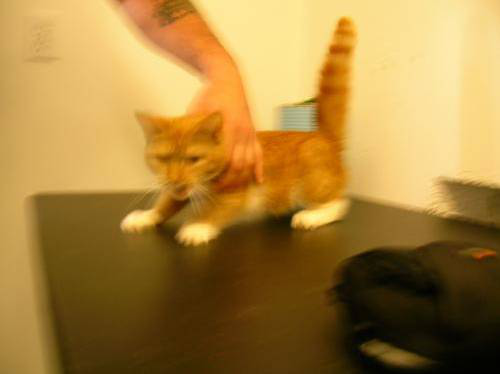

In [ ]:
im=Image.open('/content/sample_data/catvdog/cats_and_dogs_filtered/train/cats/cat.0.jpg')
im

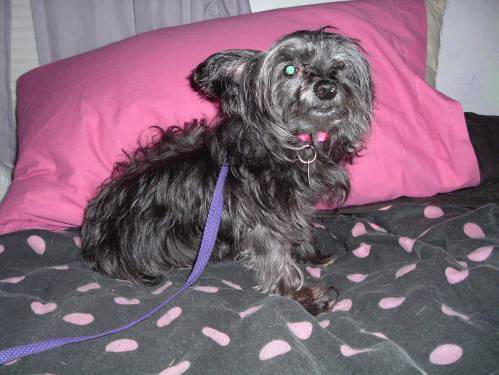

In [ ]:
im2=Image.open('/content/sample_data/catvdog/cats_and_dogs_filtered/train/dogs/dog.0.jpg')
im2

# Converting the Folders into dataset

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [ ]:
input_path='/content/sample_data/catvdog/cats_and_dogs_filtered'
data_image={
    'train': datasets.ImageFolder(input_path+'/train',data_transforms['train'])
    , 'test':datasets.ImageFolder(input_path+'/validation',data_transforms['validation'])
    
    
}

In [ ]:
train_loader=torch.utils.data.DataLoader(data_image['train'],
                                batch_size=1,
                                shuffle=True,
                                num_workers=0)

In [ ]:
validation_loader=torch.utils.data.DataLoader(data_image['test'],
                                batch_size=1,
                                shuffle=True,
                                num_workers=0)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

training images
tensor(1)
torch.Size([3, 224, 224])


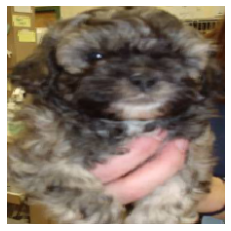

In [ ]:
trainimages, trainlabels = next(iter(train_loader))

print('training images')

imshow(trainimages[0])
print(trainlabels[0])

print(trainimages[0].size())

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Creating the CNN neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(3,6,3)
        self.conv2=nn.Conv2d(6,16,3)
        self.f1=nn.Linear(16*54*54,2)     

    def forward(self,x):
        x=torch.tensor(x,dtype=self.conv1.weight.dtype)
        x=F.max_pool2d(self.conv1(x),(2,2))
        x=F.max_pool2d(self.conv2(x),2)
        x=x.view(-1,self.get_size(x))
        x=self.f1(x)
        return x
    def get_size(self,x):
        nn=1
        ps=x.size()[1:]
        for i in ps:
            nn*=i
        return nn

In [ ]:
cnn=CNN()
cnn=cnn.to(device)

In [ ]:
# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [ ]:
batch_size=1
n_iters = 10000
num_epochs = n_iters / (8005 / batch_size)
num_epochs = int(num_epochs)

# Training The Model

In [ ]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
accuracy_list=[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(1, 3,224,224)).to(device)
        labels = Variable(labels).to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = cnn(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in validation_loader: 
                test = Variable(images.view(1,3,224,224)).to(device)
                labels=Variable(labels).to(device)
                
                # Forward propagation
                outputs = cnn(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 4.986940383911133  Accuracy: 49.60000228881836%
Iteration: 1000  Loss: 1.5965969562530518  Accuracy: 47.70000076293945%
Iteration: 1500  Loss: 0.27590852975845337  Accuracy: 60.500003814697266%
Iteration: 2000  Loss: 1.090686559677124  Accuracy: 61.500003814697266%


In [ ]:
plt.plot(iteration_list,loss_list)
plt.plot(iteration_list,np.array(accuracy_list)/100)

It's a dog


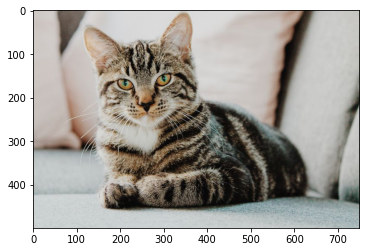

In [ ]:
catty=Image.open('/content/sample_data/catvdog/cats_and_dogs_filtered/Prediksi/607ba95f8d6f7.jpg')
plt.imshow(Image.open('/content/sample_data/catvdog/cats_and_dogs_filtered/Prediksi/607ba95f8d6f7.jpg'))
catty=catty.resize((224,224),resample=0)
val=np.array(catty).astype(float)
val=torch.from_numpy(val).cuda()
if torch.max(cnn(val.view(1,3,224,224)).data, 1)[1]==0 :
    print("It's a cat")
else:
    print("It's a dog")

It's a dog


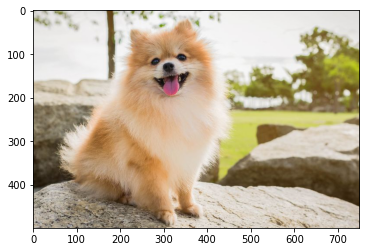

In [ ]:
catty=Image.open('/content/sample_data/catvdog/cats_and_dogs_filtered/Prediksi/5fb91dd23b3c5.jpg')
plt.imshow(Image.open('/content/sample_data/catvdog/cats_and_dogs_filtered/Prediksi/5fb91dd23b3c5.jpg'))
catty=catty.resize((224,224),resample=0)
val=np.array(catty).astype(float)
val=torch.from_numpy(val).cuda()
if torch.max(cnn(val.view(1,3,224,224)).data, 1)[1]==0 :
    print("It's a cat")
else:
    print("It's a dog")